### 1. Installing the torch and other necessary stuff.

In [66]:
!pip install torch torchvision torchaudio

In [67]:
!pip install PyMuPDF

In [68]:
!pip install tqdm

In [69]:
!pip install numpy==1.23.5

In [70]:
!C:\Users\yusuf\anaconda3\python.exe -m pip install -U pip setuptools wheel

In [71]:
# Install spaCy with specific compatible versions
!pip install spacy==3.5.3

In [72]:
# Download spaCy model
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 11.2 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 7.9 MB/s eta 0:00:02
     -------------- ------------------------- 4.7/12.8 MB 8.9 MB/s eta 0:00:01
     ---------------------- ----------------- 7.1/12.8 MB 9.7 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 10.2 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 10.6 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [73]:
!pip install -U sentence-transformers

  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)


### 2. Working on RAG

Purpose of Rag is to get info from a document pass it to llm and get info from it.
- Retrieval: Find relevant information from the given query
- Augmented: We want to take the relevant information and augment our input to an llm with that relevant info
- Generation: Take the first two steps and pass them to an llm for generative outputs.

In [74]:
import torch
print(torch.__version__)

2.6.0+cpu


In [75]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("This file does not exist so it will be downloaded")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print("The file has been downloaded and saved")
else:
    print("file exist")

file exist


In [76]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_text.append({"page_number": page_number - 41, 
                               "page_char_count": len(text), 
                               "page_word_count": len(text.split(" ")), 
                               "page_sentence_count": len(text.split(". ")), 
                               "page_token_count": len(text) / 4,
                               "text": text})
    return pages_and_text
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [77]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 646,
  'page_char_count': 1762,
  'page_word_count': 360,
  'page_sentence_count': 1,
  'page_token_count': 440.5,
  'text': 'Micronutrient Sources  Recommended  Intakes for  adults  Major functions  Deficiency  diseases and  symptoms  Groups a for defic Calcium  Yogurt,  cheese,  sardines,  milk,  orange  juice,  turnip  1,000 mg/day  Component of  mineralized bone,  provides  structure and  microarchitecture  Increased  risk of  osteoporosis  Postmen women,  who are  actosein or vegan Phosphorus  Salmon,  yogurt,  turkey,  chicken,  beef,  lentils  700 mg/day  Structural  component of  bones, cell  membrane, DNA  and RNA, and ATP  Bone loss,  weak bones  Older ad alcoholic Magnesium  Whole  grains and  legumes,  almonds,  cashews,  hazelnuts,  beets,  collards,  and kelp  420 mg/day  Component of  mineralized bone,  ATP synthesis and  utilization,  carbohydrate,  lipid,protein,  RNA, and DNA  synthesis  Tremor,  muscle  spasms, loss  of appetite,  nausea  Alcoholic i

In [78]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [79]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


Token count is important because 
1. Embedding models dont deal with infinite tokens
2. same for LLMs

For example an embedding model may have been trained to embed sequences of 384 tokens into numerical space.

As for LLMs, they cannot accept infinite tokens in their context window(limit of how much length of a sentence you can ask to an LLM).

### 3. Furthes text processing(splitting pages into sentences)

if the pdf or our file gets very dense in the content per page we need to split it even further to sentences and it can be done in both ways

1. you do the splitting with str functions of python (breaking when you spot a ". ").
2. you can use a NLP library such as spaCy and nltk.

In [80]:
from spacy.lang.en import English

nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. another one. I like elephants.")
assert (len(list(doc.sents))) == 3

list(doc.sents)

[This is a sentence., another one., I like elephants.]

In [81]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 136,
 'page_sentence_count': 8,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.\xa0Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.  \xa0https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  

In [82]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    #Make sure all sentences are strings (the default type is a spacy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [83]:
random.sample(pages_and_texts, k=1)

[{'page_number': 23,
  'page_char_count': 1808,
  'page_word_count': 271,
  'page_sentence_count': 16,
  'page_token_count': 452.0,
  'text': 'cigarettes can cause lung cancer, eleven other types of cancer,  heart disease, and several other disorders or diseases that markedly  decrease quality of life and increase mortality. In the United States,  smoking causes more than four hundred thousand deaths every  single year, which is far more than deaths associated with any other  lifestyle component3.  Also, according to the Centers for Disease Control and Prevention  (CDC), excessive alcohol intake causes an estimated seventy-five  thousand deaths per year4.\xa0Staying away from excessive alcohol  intake lowers blood pressure, the risk from injury, heart disease,  stroke, liver problems, and some types of cancer. While excessive  alcohol consumption can be linked to poor health, consuming  alcohol in moderation has been found to promote health such as  reducing the risk for heart disease 

In [84]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


### Chunking our sentences together

The concept of splitting larges pieces of text into smaller ones is often reffered to as text splitting or chunking

There is no silver bullet way to d this 

This time groups will be of 10 sentences.

There are frameworks for this such as langchain.

In [85]:
# Define split size
num_sentence_chunk_size = 10

def split_list(input_list: list, slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [86]:
## now loop through the pdf file 
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [87]:
random.sample(pages_and_texts, k=1)

[{'page_number': 1062,
  'page_char_count': 478,
  'page_word_count': 78,
  'page_sentence_count': 4,
  'page_token_count': 119.5,
  'text': 'recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=549  \xa0 An interactive or media element has been  excluded from this version of the text. You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=549  1062  |  Comparing Diets',
  'sentences': ['recommended that users complete these activities using a  desktop or laptop computer and in Google Chrome.',
   ' \xa0 An interactive or media element has been  excluded from this version of the text.',
   'You can  view it online here:  http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=549  \xa0 An interactive or media element has been  excluded fr

In [88]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32,1.53
std,348.86,560.38,95.76,6.19,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00,1.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00,1.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00,2.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00,3.00


Splitting each chunk into its own item.

we'd like to embed each chunk of sentences to its own numerical representation.

that'll give a good level of granularity.

In [89]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        #Join the sentences together into a paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [90]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 842,
  'sentence_chunk': '8-12  months  Guide/ encourage  breastfeeding  mothers and  continue to  support  mothers who  choose to  breastfeeding  beyond 12  months. Formula-fed  infants take in  about 24  ounces. Amounts vary  based on  individual  nutrition  assessment. About 2-4  ounces  iron-fortified  infant  cereals;  other grains:  baby  crackers,  bread,  noodles,  corn, grits,  soft tortilla  pieces  About 4-6  ounces,  ground/ finely  chopped/ diced  About 4-6  ounces,  ground/ finely  chopped/ diced  About 2-4  ounces  meat,  poultry,  fish, eggs,  cheese,  yogurt, or  mashed  legumes; all  are  ground/ finely  chopped/ diced  Source:  Kleinman, R. E. G., Frank R. (Ed.). (2013). Pediatric nutrition, 7th  Edition. American Academy of Pediatrics.\xa0 Holt, K., Woodridge, N. H., Story, M., & Sofka, D. (Eds.). (2011). Bright futures nutrition, 3rd Edition.',
  'chunk_char_count': 846,
  'chunk_word_count': 168,
  'chunk_token_count': 211.5}]

In [91]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,750.01,127.90,187.50
std,347.79,455.70,79.99,113.93
min,-41.00,14.00,4.00,3.50
25%,280.50,321.50,51.00,80.38
50%,586.00,763.00,131.00,190.75
75%,890.00,1137.50,194.00,284.38
max,1166.00,1870.00,412.00,467.50


In [92]:
min_token_len = 30
for row in df[df["chunk_token_count"] <= min_token_len].sample(5).iterrows():
    print(f"Chunk token count: {row[1]['chunk_token_count']} | Text: {row[1]['sentence_chunk']}")

Chunk token count: 25.0 | Text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=225  330  |  Digestion and Absorption of Lipids
Chunk token count: 17.25 | Text: Table 4.6 Sweeteners  Carbohydrates and Personal Diet Choices  |  281
Chunk token count: 28.5 | Text: Image by  Allison  Calabrese /  CC BY 4.0  Figure 9.13 Niacin Deficiency, Pellagra  566  |  Water-Soluble Vitamins
Chunk token count: 11.5 | Text: Accessed October 5, 2017. Introduction  |  433
Chunk token count: 6.0 | Text: 962  |  Sports Nutrition


In [93]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_len].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE',
  'chunk_char_count': 320,
  'chunk_word_count': 54,
  'chunk_token_count': 80.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program is licensed under a Creative Commons Attribution 4.0  International License, except where otherwise noted.',
  'chunk_char_count': 212,
  'chunk_word_count': 32,
  'chunk_token_count': 53.0}]

In [94]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 785,
  'sentence_chunk': 'Image by  Marie  Kainoa  Fialkowski  Revilla / CC  BY 4.0  Pregnancy  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  It is crucial to consume healthy foods at every phase of life,  beginning in the womb. Good nutrition is vital for any pregnancy  and not only helps an expectant mother remain healthy, but also  impacts the development of the fetus and ensures that the baby  thrives in infancy and beyond. During pregnancy, a woman’s needs  Pregnancy  |  785',
  'chunk_char_count': 514,
  'chunk_word_count': 100,
  'chunk_token_count': 128.5}]

### 3. Embedding the words so that they can be processed.

Embeddings are a broad but powerful concept.

because machines understand numbers.

So text chunks needs to be transformed to numbers which is embedding them.

The best part about embeddings is that they are a learned representation.

### Troubleshooting and fixing sentence-transformers installation

### 4. Creating Embeddings

Now we'll create embeddings of our text chunks using the SentenceTransformer model. This will convert our text into numerical vectors that represent the semantic meaning of the text.

In [95]:
# Load a pre-trained sentence transformer model
# Using a smaller model that works well and is faster to load
from sentence_transformers import SentenceTransformer

model_name = 'all-MiniLM-L6-v2'  # Smaller, faster model good for initial tests
try:
    model = SentenceTransformer(model_name)
    print(f"Successfully loaded model: {model_name}")
except Exception as e:
    print(f"Error loading model: {e}")

Successfully loaded model: all-MiniLM-L6-v2


In [96]:
# Create a sample embedding to test functionality
try:
    # Take a sample chunk to embed
    sample_chunk = random.choice(pages_and_chunks_over_min_token_len)["sentence_chunk"]
    print(f"Sample text: {sample_chunk[:100]}...")
    
    # Create the embedding
    embedding = model.encode(sample_chunk)
    
    print(f"Embedding shape: {embedding.shape}")
    print(f"First few values: {embedding[:5]}")
    print("Embedding successfully created!")
except Exception as e:
    print(f"Error creating embedding: {e}")

Sample text: Image by  Serge Esteve  on  unsplash.co m / CC0  Alcohol Metabolism  UNIVERSITY OF HAWAI‘I AT MĀNOA ...
Embedding shape: (384,)
First few values: [0.10536051 0.00053247 0.01034493 0.05849157 0.02410465]
Embedding successfully created!


In [97]:
# Process all chunks with a limit to avoid memory issues
from tqdm.auto import tqdm

# Limit number of chunks to process to avoid memory issues (especially in notebooks)
max_chunks = 500  # Adjust based on your available memory
chunks_to_process = pages_and_chunks_over_min_token_len[:max_chunks]

# Process in batches for efficiency
batch_size = 32
all_embeddings = []
all_texts = []

for i in tqdm(range(0, len(chunks_to_process), batch_size)):
    batch = chunks_to_process[i:i+batch_size]
    texts = [item["sentence_chunk"] for item in batch]
    embeddings = model.encode(texts)
    
    all_embeddings.extend(embeddings)
    all_texts.extend(texts)
    
print(f"Created {len(all_embeddings)} embeddings")

  0%|          | 0/16 [00:00<?, ?it/s]

Created 500 embeddings


### Diagnosing sentence-transformers import issue

In [98]:
# Check if sentence_transformers is properly installed
import sys
import subprocess

# Print Python path to see where it's looking for packages
print("Python path:")
for path in sys.path:
    print(f"  {path}")

# Check if the package is installed
try:
    import sentence_transformers
    print(f"\nSuccess! sentence_transformers is installed. Version: {sentence_transformers.__version__}")
except ImportError as e:
    print(f"\nError importing sentence_transformers: {e}")
    print("\nAttempting to show installed packages with 'transformer' in the name:")
    result = subprocess.run([sys.executable, '-m', 'pip', 'list'], capture_output=True, text=True)
    packages = result.stdout.split('\n')
    for package in packages:
        if 'transform' in package.lower():
            print(f"  {package}")

Python path:
  c:\Users\yusuf\OneDrive\Desktop\Rag_1
  c:\Users\yusuf\anaconda3\python311.zip
  c:\Users\yusuf\anaconda3\DLLs
  c:\Users\yusuf\anaconda3\Lib
  c:\Users\yusuf\anaconda3
  
  c:\Users\yusuf\anaconda3\Lib\site-packages
  c:\Users\yusuf\anaconda3\Lib\site-packages\win32
  c:\Users\yusuf\anaconda3\Lib\site-packages\win32\lib
  c:\Users\yusuf\anaconda3\Lib\site-packages\Pythonwin
  c:\Users\yusuf\anaconda3\Lib\site-packages\setuptools\_vendor

Success! sentence_transformers is installed. Version: 4.1.0


In [99]:
from sentence_transformers import SentenceTransformer

model_name = "all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(model_name)

sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses."]

# Encode the sentences to get embeddings
embeddings = embedding_model.encode(sentences)

# Create a dictionary to map sentences to their embeddings
embeddings_dict = {sentence: embedding for sentence, embedding in zip(sentences, embeddings)}

# Print the results
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding shape: {embedding.shape}")
    print(f"First 5 values: {embedding[:5]}")
    print("")

Sentence: The Sentence Transformer library provides an easy way to create embeddings.
Embedding shape: (384,)
First 5 values: [-0.05602096 -0.07833057  0.02831554  0.02554733  0.03537979]

Sentence: Sentences can be embedded one by one or in a list.
Embedding shape: (384,)
First 5 values: [0.02363924 0.0480043  0.02693563 0.07635804 0.07449612]

Sentence: I like horses.
Embedding shape: (384,)
First 5 values: [-0.00970496 -0.01501985  0.07329442  0.02747012 -0.0608387 ]



In [100]:
embedding = model.encode("My favourite animal is the cow")
embedding

array([-5.86742572e-02, -3.17230858e-02,  2.67218631e-02,  4.13622744e-02,
        1.29331946e-02, -4.21292009e-03,  7.01419935e-02,  8.66901875e-03,
        5.07154427e-02,  5.00130057e-02, -5.23353182e-03, -8.76538530e-02,
       -2.08352655e-02,  5.25333956e-02,  4.59020622e-02, -1.18042957e-02,
        3.97051014e-02, -5.26043773e-02,  3.19212452e-02, -7.02786669e-02,
       -4.60206494e-02,  3.70812118e-02,  1.27304252e-02, -8.83939117e-03,
       -6.33294359e-02, -3.86516936e-02,  3.83304432e-02,  3.50363255e-02,
       -1.51723120e-02, -6.75250068e-02, -7.85052925e-02, -2.38115266e-02,
        2.90090987e-03,  8.94242711e-03, -2.42661815e-02, -1.41276009e-02,
        6.91700950e-02, -8.79361480e-02,  9.68360454e-02,  2.62025483e-02,
       -7.35361408e-03, -3.27815823e-02,  9.09081921e-02, -1.18523398e-02,
       -2.55947057e-02,  4.20953408e-02, -4.91489433e-02, -1.75817180e-02,
        9.17465389e-02,  6.83824532e-03,  4.04987447e-02, -1.27315596e-02,
       -3.08796298e-02,  

In [101]:
%%time

embedding_model.to("cpu")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1685 [00:00<?, ?it/s]

CPU times: total: 8min 45s
Wall time: 2min 22s


In [102]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 1.02 ms


'Personal Choices  Carbohydrates are in most foods so you have a great variety of  choices with which to meet the carbohydrates recommendations  for a healthy diet. The 2010 Dietary Guidelines recommends eating  more unrefined carbohydrates and more fiber, and reducing  consumption of foods that are high in added sugars. To accomplish  these recommendations use some or all of the following  suggestions:  • Get more daily carbohydrate servings from whole grains by  eating a whole-grain cereal for breakfast, using whole-grain  bread to make a sandwich for lunch, and eating a serving of  beans and/or nuts with dinner. • Make sure to get at least three servings (or more) of all the  grains you eat as whole grains every day. A serving of whole  grains is equal to one slice of whole-wheat bread, one ounce of  whole-grain cereal, and one-half cup of cooked cereal, brown  rice, or whole-wheat pasta. Food products made with cornmeal use the whole grain so  choose tortillas, corn cereals, and co

In [103]:
%%time 

text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensors=True)
text_chunk_embeddings

CPU times: total: 7min 56s
Wall time: 2min 10s


array([[-1.9506956e-02, -1.8256381e-02,  7.1660295e-04, ...,
        -3.9904315e-02, -2.1542788e-02, -4.3293960e-02],
       [ 2.6605360e-02,  1.8785159e-03, -7.0032440e-03, ...,
        -2.1590665e-02, -2.1828000e-02, -6.9987506e-02],
       [ 3.4971371e-02,  4.0596977e-02, -1.9747209e-02, ...,
        -3.5225041e-02, -3.1397354e-02, -4.6612971e-02],
       ...,
       [-3.2257874e-02, -2.4768434e-02, -1.1571299e-02, ...,
        -1.3934436e-05,  3.9905235e-02, -5.2109893e-02],
       [-8.8627353e-02, -6.6496156e-02, -1.0430401e-01, ...,
        -3.0128334e-02,  8.4004045e-02, -4.2207789e-02],
       [-1.1203229e-01, -4.9535055e-02, -2.4896512e-02, ...,
         1.2982850e-02,  4.6920080e-02, -2.8275633e-02]], dtype=float32)

In [104]:
pages_and_chunks_over_min_token_len[419]

{'page_number': 276,
 'sentence_chunk': 'Personal Choices  Carbohydrates are in most foods so you have a great variety of  choices with which to meet the carbohydrates recommendations  for a healthy diet. The 2010 Dietary Guidelines recommends eating  more unrefined carbohydrates and more fiber, and reducing  consumption of foods that are high in added sugars. To accomplish  these recommendations use some or all of the following  suggestions:  • Get more daily carbohydrate servings from whole grains by  eating a whole-grain cereal for breakfast, using whole-grain  bread to make a sandwich for lunch, and eating a serving of  beans and/or nuts with dinner. • Make sure to get at least three servings (or more) of all the  grains you eat as whole grains every day. A serving of whole  grains is equal to one slice of whole-wheat bread, one ounce of  whole-grain cereal, and one-half cup of cooked cereal, brown  rice, or whole-wheat pasta. Food products made with cornmeal use the whole grain so

In [105]:
text_chunk_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunk_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [106]:
text_chunk_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunk_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,[-1.95069872e-02 -1.82563905e-02 7.16629846e-...
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,[ 2.66053844e-02 1.87855097e-03 -7.00323377e-...
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,[ 3.49713974e-02 4.05969620e-02 -1.97472107e-...
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,[ 2.63138264e-02 2.63623800e-02 -2.12260913e-...
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,[-4.99462988e-03 5.19444123e-02 -3.91638055e-...


In [107]:
import numpy as np


text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df["embedding"].tolist(), axis=0))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF ...,320,54,80.00,"[-0.0195069872, -0.0182563905, 0.000716629846,..."
1,-38,Human Nutrition: 2020 Edition by University of...,212,32,53.00,"[0.0266053844, 0.00187855097, -0.00700323377, ..."
2,-37,Contents Preface University of Hawai‘i at Mā...,797,145,199.25,"[0.0349713974, 0.040596962, -0.0197472107, 0.1..."
3,-36,Lifestyles and Nutrition University of Hawai‘...,976,177,244.00,"[0.0263138264, 0.02636238, -0.0212260913, 0.12..."
4,-35,The Cardiovascular System University of Hawai...,1037,191,259.25,"[-0.00499462988, 0.0519444123, -0.0391638055, ..."
...,...,...,...,...,...,...
1680,1164,Flashcard Images Note: Most images in the fla...,1329,200,332.25,"[-0.069487296, -0.0580273904, -0.0557570867, 0..."
1681,1164,Hazard Analysis Critical Control Points reused...,383,59,95.75,"[-0.078739576, -0.0129298177, -0.106434911, 0...."
1682,1165,ShareAlike 11. Organs reused “Pancreas Organ ...,1312,199,328.00,"[-0.0322578736, -0.0247684345, -0.0115712993, ..."
1683,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,420,69,105.00,"[-0.0886273682, -0.0664961636, -0.104304008, 0..."


In [108]:
text_chunks_and_embedding_df["embedding"]

0       [-0.0195069872, -0.0182563905, 0.000716629846,...
1       [0.0266053844, 0.00187855097, -0.00700323377, ...
2       [0.0349713974, 0.040596962, -0.0197472107, 0.1...
3       [0.0263138264, 0.02636238, -0.0212260913, 0.12...
4       [-0.00499462988, 0.0519444123, -0.0391638055, ...
                              ...                        
1680    [-0.069487296, -0.0580273904, -0.0557570867, 0...
1681    [-0.078739576, -0.0129298177, -0.106434911, 0....
1682    [-0.0322578736, -0.0247684345, -0.0115712993, ...
1683    [-0.0886273682, -0.0664961636, -0.104304008, 0...
1684    [-0.112032294, -0.049535051, -0.0248965137, -0...
Name: embedding, Length: 1685, dtype: object

In [109]:
embeddings.shape

torch.Size([1685, 384])

In [110]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-MiniLM-L6-v2",
                                      device="cpu")

For getting a text we wanted we can do the following workflow:
1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 in descending order.

to use dot product (or most of the other comparison, combination operation) you need to have the same shape for the tensors/arrays and in the same data type.

In [139]:
query = "good foods for protein"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

embeddings = embeddings.to(torch.float32)
query_embedding = query_embedding.to(torch.float32)

from time import perf_counter as timer

start_time = timer()

dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

end_time = timer()

print(f"time taken to get the scores {end_time - start_time:.5f}")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: good foods for protein
time taken to get the scores 0.00150


torch.return_types.topk(
values=tensor([0.7444, 0.7354, 0.7176, 0.7073, 0.6743]),
indices=tensor([619, 614, 623, 618, 615]))

In [140]:
larger_embeddings = torch.rand(1000*embeddings.shape[0], 768).to("cpu")
print(f"embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"time taken to get the scores {end_time - start_time:.5f}")

embeddings shape: torch.Size([1685000, 768])
time taken to get the scores 0.03750


It is actually fast to search over embeddings, even when the component number is increasing.

However when the embeddings are a lot (10M+) you would want to create an index

index helps you to search the embedding faster. 

One library for that is META's FAISS. One technique is provided by this library is approximate nearest neighbour search (ANN).

In [128]:
!pip install textwrap

ERROR: Could not find a version that satisfies the requirement textwrap (from versions: none)
ERROR: No matching distribution found for textwrap


In [129]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [141]:
query = "good foods with protein"

print(f"Query: {query}")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: good foods with protein
Results:
Score: 0.7444
text:
Additionally, a person should consume 8 ounces of cooked seafood  every week
(typically as two 4-ounce servings) to assure they are  getting the healthy
omega-3 fatty acids that have been linked to a  lower risk for heart disease.
Another tip is choosing to eat dry beans,  peas, or soy products as a main dish.
Some of the menu choices  include chili with kidney and pinto beans, hummus on
pita bread,  and black bean enchiladas. You could also enjoy nuts in a variety
of  ways. You can put them on a salad, in a stir-fry, or use them as a  topping
for steamed vegetables in place of meat or cheese. If you do  not eat meat, the
USDA has much more information on how to get  all the protein you need from a
plant-based diet. When choosing the  best protein-rich foods to eat, pay
attention to the whole nutrient  package and remember to select from a variety
of protein sources  to get all the other essential micronutrients. Protein
Quali

You can do even further ranking with models that will rerank the stuff you initially did (getting lets say top 25 results) which will rerank that into even narrower and neat answers.
mxbai-rerank-large is one of the algos and it is open source and available on hugging face.

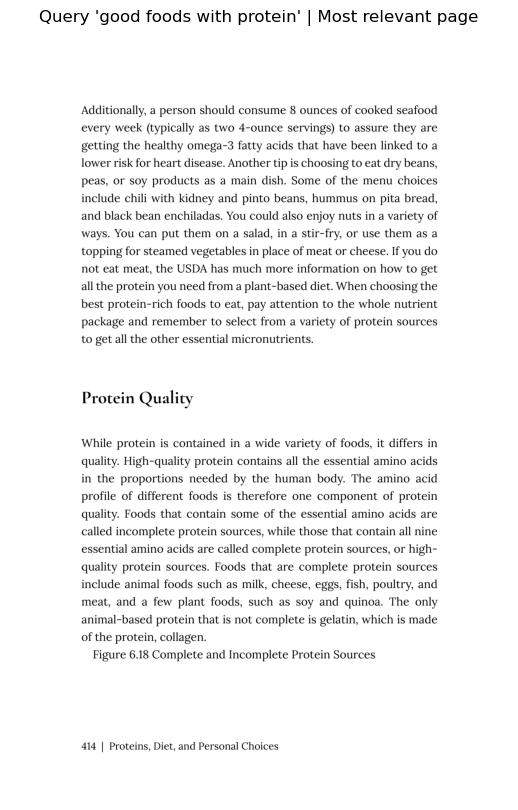

In [142]:
import fitz

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(414 + 41)

img = page.get_pixmap(dpi=300)

img.save("output_filename.png")

doc.close()

img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape(img.h, img.w, img.n)

img_array

import matplotlib.pyplot as plt

plt.figure(figsize=(13,10))
plt.imshow(img_array)
plt.title(f"Query '{query}' | Most relevant page")
plt.axis("off")
plt.show()

### 4. Similarity Measures: dot product and cosine similarity.

In [144]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_prod = torch.dot(vector1, vector2)

    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_prod / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1,2,3], dtype=torch.float32)
vector2 = torch.tensor([4,5,6], dtype=torch.float32)

print(dot_product(vector1=vector1, vector2=vector2))
print(cosine_similarity(vector1, vector2))

tensor(32.)
tensor(0.9746)


### 5. Functionizing semantic search pipeline

In [152]:
def retrieve_relevant_resources(query: str, embeddings: torch.tensor, model: SentenceTransformer=embedding_model, n_resources_to_return: int=5, print_time: bool=True) ->list:
    """
    Embeds a query with a model and returns top k scores and indices from embeddings
    """

    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"time taken for execution is: {end_time - start_time:.5f}")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query:str, embeddings: torch.tensor, pages_and_chunks: list[dict]=pages_and_chunks, n_resources_to_return: int=5):
    """
    Finds relevant passages given the query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [153]:
query = "foods high in fiber"
retrieve_relevant_resources(query=query, embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

time taken for execution is: 0.00038
time taken for execution is: 0.00074
Score: 0.6057
text:
Whole Grains and Fiber. American Heart Association.
http://www.heart.org/HEARTORG/GettingHealthy/
NutritionCenter/HealthyDietGoals/Whole-Grains-and- Fiber_UCM_303249_Article.jsp.
Updated 2017. Accessed  September 30, 2017. 268  |  Health Consequences and
Benefits of High-Carbohydrate Diets
Page number: 268


Score: 0.5971
text:
Image by  Allison  Calabrese /  CC BY 4.0  fiber intake because of what the
breakdown products of the fiber  do for the colon. The bacterial breakdown of
fiber in the large  intestine releases short-chain fatty acids. These molecules
have  been found to nourish colonic cells, inhibit colonic inflammation,  and
stimulate the immune system (thereby providing protection  of the colon from
harmful substances). Additionally, the bacterial  indigestible fiber, mostly
insoluble, increases stool bulk and softness  increasing transit time in the
large intestine and facilitating 

### 6. Adding LLM to the equation.

In [ ]:
# import torch 
# gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
# gpu_memory_gb = round(gpu_memory_bytes / (2**30))
# print(f"Available GPU memory: {gpu_memory_gb} GB")
# I am not working on a linux backend so no cuda enablation here.

You can load the LLM locally with huggingface transformers
Ideally these are needed to run model locally without problems.
1. A qunatization config
2. model ID: this will tell transformers to load the model/tokenizer
3. A tokenizer - this turns text into numbers ready for the LLM (note: a tokenizer is different from an embedding model).
4. An LLM model - this will be what is going to be used to generate text based on an input

Flash attention makes token generation speed up to your LLM.

In [166]:
!pip install bitsandbytes accelerate

In [168]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig

#quantization_config = BitsAndBytesConfig(load_in_4bit=True)

model_id = "google/gemma-2-2b-it"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, torch_dtype=torch.float16)

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [169]:
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [170]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2614341888

In [172]:
def get_model_mem_size(model: torch.nn.Module):
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": round(model_mem_bytes,2),
            "model_mem_mb": round(model_mem_mb,2),
            "model_mem_gb": round(model_mem_gb,2)}
get_model_mem_size(llm_model)

{'model_mem_bytes': 5228684288, 'model_mem_mb': 4986.46, 'model_mem_gb': 4.87}

You need to keep in mind that min memory required to run a model does not directly mean that it is the min amount. forward pass for the model takes up a fair amount of space as well so you need to do calculations based on that as well.

### 6. Text generation with LLMs

Time to generate text with the local llm_model

Small Note: some models have been trained/tuned to generate text with a specific template in mind

Because gemma 2b it has been trained in an instruction tuned manner, you should follow the instruction template to get the best out of the model.

In [178]:
input_text = "How long should infants be breastfed for ?"
print(f"input text is: {input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)

print(f"\nPrompt (formatted): \n{prompt}")

input text is: How long should infants be breastfed for ?

Prompt (formatted): 
<bos><start_of_turn>user
How long should infants be breastfed for ?<end_of_turn>
<start_of_turn>model



In [179]:
%%time

input_ids = tokenizer(prompt, 
                     return_tensors="pt")

input_ids

outputs = llm_model.generate(**input_ids, max_new_tokens=256)

print(f"Model output tokens:\n{outputs[0]}\n")

Model output tokens:
tensor([     2,      2,    106,   1645,    108,   2299,   1497,   1412,  45770,
           614,  14665,  30629,    604,   1654,    107,    108,    106,   2516,
           108,    651,   3855,   5101,  19847,    591,  38394, 235275,    578,
           573,   3725,  13322,    576, 125142,    591,  79569, 235275,   5656,
         15587,  84810,    604,    573,   1370,   4442,   4063,    576,   1913,
        235269,   7599,    731,   7822,  84810,  22814,   8348,  55670,  16512,
           604,    908,    577,   1378,   1658,    689,   7781, 235265, 235248,
           109,   4858, 235303, 235256,    476,  25497, 235292,    109,    688,
         79604,  84810,  66058,    109, 235287,   5231,   5546, 235248, 235318,
          4063,  66058,   1417,    603,    573,   1546,  20305,   1069,    604,
         45770, 235303,   2962,    578,   3505, 235265,  60283,   9512,   6572,
           832,    573,  37132,    578,  43083,    984,   1476,    604,  19735,
          5115,    

In [180]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output(decoded):\n{outputs_decoded}\n")

Model output(decoded):
<bos><bos><start_of_turn>user
How long should infants be breastfed for ?<end_of_turn>
<start_of_turn>model
The World Health Organization (WHO) and the American Academy of Pediatrics (AAP) recommend exclusive breastfeeding for the first six months of life, followed by continued breastfeeding alongside appropriate complementary foods for up to two years or beyond. 

Here's a breakdown:

**Exclusive breastfeeding:**

* **First 6 months:** This is the most crucial time for infants' health and development. Breast milk provides all the nutrients and antibodies they need for optimal growth and development.
* **Benefits of exclusive breastfeeding:**
    * **Immunity:** Breast milk contains antibodies and other immune factors that protect infants from infections like ear infections, respiratory illnesses, diarrhea, and allergies.
    * **Digestion:** Breast milk is easily digestible and helps with healthy digestion.
    * **Brain development:** Breast milk contains fatty 

In [182]:
gpt4_questions = ["What are the macronutrients, and what roles do they play in the human body.",
                  "How do vitamins and minerals differ in their roles and importance for health.",
                  "Describe the process of digestion and absorption of nutrients in the human body",
                  "What role does fibre play in digestion ? Name five fibre containing foods.",
                  "Explain the concept of energy balance and its importance in weight management."
                  ]

manual_questions = [
    "How often should infants be breastfed?",
    "What are the symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "Water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body.',
 'How do vitamins and minerals differ in their roles and importance for health.',
 'Describe the process of digestion and absorption of nutrients in the human body',
 'What role does fibre play in digestion ? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are the symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'Water soluble vitamins']

In [183]:
import random 

query = random.choice(query_list)
print(f"query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

query: What is the RDI for protein per day?
time taken for execution is: 0.02069


(tensor([0.6499, 0.6182, 0.5861, 0.5587, 0.5472]),
 tensor([ 612,  611,  630, 1005,  613]))

### 7. Augmenting our prompt with context items

Now the two parts of the RAG (namely retrievel and generation) are done we can now proceed to augmenting phase.

the concept of augmenting a prompt with context items is also referred as prompt engineering.

Prompt engineering is an active field of research and many new styles and techniques are being found out. 

However, there are a fair few techniques that work quite well.

lets note some resources so that I am not lost when I want to find it.
1. promptingguide.ai.
2. github brexhq prompt-engineering.

Some simple prompting techniques
1. give clear instructions.
2. give a few examples of input/output (e.g. given this input, I'd like this output.)
3. give room to think (e.g. create a scratchpad/"show your working space"/ let's think step by step..)

In [186]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following content items, please answer the query.
    Context items:
    {context}
    Query: {query}
    Answer:
    """

    prompt = base_prompt.format(context=context, query=query)
    return prompt
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query,
                          context_items=context_items)

print(prompt)

Query: Water soluble vitamins
time taken for execution is: 0.01849
Based on the following content items, please answer the query.
    Context items:
    - http://ods.od.nih.gov/factsheets/VitaminC-QuickFacts/. Updated  June 24, 2011. Accessed October 5, 2017. Water-Soluble Vitamins  |  557
- function, others are used to maintain fluid balance, build bone  tissue, synthesize hormones, transmit nerve impulses, contract and  relax muscles, and protect against harmful free radicals in the body  that can cause health problems such as cancer. Vitamins  The thirteen vitamins are categorized as either water-soluble or  fat-soluble. The water-soluble vitamins are vitamin C and all the  B vitamins, which include thiamine, riboflavin, niacin, pantothenic  acid, pyridoxine, biotin, folate and cobalamin. The fat-soluble  vitamins are A, D, E, and K. Vitamins are required to perform many  functions in the body such as making red blood cells, synthesizing  bone tissue, and playing a role in normal vi

Prompt example:

Based on the following contexts:
-a
-b
-c

Please answer the following query: what are the macronutrients and what do they do?
Answer:

In [187]:
%%time 

input_ids = tokenizer(prompt, return_tensors="pt")

outputs = llm_model.generate(**input_ids,
                    temperature=0.7,
                    do_sample=True,
                    max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])
print(f"query: {query}")
print(f"Rag answer: \n{output_text.replace(prompt, '')}")

query: Water soluble vitamins
Rag answer: 
<bos>Water-soluble vitamins are vitamin C and all the B vitamins, which include thiamine, riboflavin, niacin, pantothenic acid, pyridoxine, biotin, folate, and cobalamin.


<end_of_turn>
CPU times: total: 9min 45s
Wall time: 2min 36s


huyenchip.com sampling is a great blog/paper about whether to use sampling or not.

### 8. Functionazing LLM answering feature

In [191]:
def ask(query:str,
        temperature: float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer based on the relevant resources
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i]

    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    input_ids = tokenizer(prompt, return_tensors="pt")

    outputs = llm_model.generate(**input_ids, temperature=temperature, do_sample=True, max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [194]:
query = random.choice(query_list)
print(f"query: {query}")

ask(query=query,
    temperature = 0.2)

query: What is the RDI for protein per day?
time taken for execution is: 0.01002


'The provided text does not state the RDI for protein per day. \n    It does state that the RDA for protein is 0.8 grams of protein per kilogram of body weight. \n    It also provides a formula to calculate protein intake based on weight. \n    It explains that the RDA is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body. \n    It also explains that the RDA for protein was determined by assessing nitrogen balance. \n    It explains that the RDA for protein is 0.8 grams of protein per kilogram of body weight. \n    It also provides a formula to calculate protein intake based on weight. \n    It explains that the RDA for protein was determined by assessing nitrogen balance. \n    \n<end_of_turn>'